# This is an experiment to show how noise effects entropy

## Intuition

When we try to create a custom noise model (https://docs.quantum.ibm.com/guides/build-noise-models), we essentially add random gates (call it noisy gates), in front of existing gates in the quantum circuit. Let us assume that we are working on a quantum algorithm that is written correctly(i.e. there are no bugs), however while doing experiments on an actual quantum computer, we could actually get some wrong answers. This is due to noise.

For simplicity, let us assume that the quantum algorithm we are working almost likely gives a single state as the answer after measurement in the absence of noise. However the nosie can have several effects. As we have seen in earlier modules that bugs can lead to any arbitrary state depending on the type of bug and how it is affecting the quantum system. Therefore, it is quite likely that instead of getting our desired answer, we deviate from the answer due to noisy gates. However, this deviation depends on the noise level (read the paper for definition). The higher the nosie level, the higher the deviation could be. Now, we claim that as noise level increases, the entropy also increases. This is because, with some probability, we are applying random gates. Thus this could be thought of as arbitratily changing our answer a certain number of times. We denote this probability of changing our answer as the noise level, and as long as this is in control, i.e. does not overshadow the actual answer, we would get our correct answers with higher probability, but the other states would also increase.

Thereotically, let us test our assumption out on the deutch josza algorithm for simplicity.

https://github.com/filipecorrea/deutsch-jozsa/blob/master/deutsch-jozsa-constant.ipynb

## Experiments

Now, we will conduct the experiments on the actual backend and fake noises provided by qiskit, which are taken at random timestamps from the actual quantum computer

(https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake-provider)

In [1]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

from math import log2
import numpy as np

In [9]:
# The following function calculates the entropy of the final measurement
def calculate_entropy(output_map):
    total_count = sum(output_map.values())
    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return entropy

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Let us list the services provided by the backend noises
service = QiskitRuntimeService()
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>]


As per (https://arxiv.org/pdf/2307.16130), the average number of qubits used are 10.5 and the median is 6. Thus we will test on circuits of qubits 2-15 

In [7]:
import numpy as np

# Define the desired mean and median of the lognormal distribution
desired_mean = 10
desired_median = 6.5

# The median of a lognormal distribution is exp(mu), where mu is the mean of the underlying normal distribution.
# So, we solve for mu: exp(mu) = desired_median
mu = np.log(desired_median)

# The mean of a lognormal distribution is exp(mu + sigma^2/2), where sigma is the standard deviation of the underlying normal distribution.
# We solve for sigma: exp(mu + sigma^2/2) = desired_mean
sigma_squared = 2 * np.log(desired_mean / desired_median)
sigma = np.sqrt(sigma_squared)

# Generate numbers from the lognormal distribution
qubits = np.random.lognormal(mean=mu, sigma=sigma, size=1000)

# Randomly decide whether to round up or down for each number
round_choices = np.random.choice([0, 1], size=len(qubits))  # 0 for floor, 1 for ceil

# Apply the rounding
qubits = np.where(round_choices == 0, np.floor(qubits), np.ceil(qubits))

# Ensure natural numbers
qubits = np.maximum(qubits, 1).astype(int)

# Check the mean and median of the generated numbers
print("Mean:", np.mean(qubits))
print("Median:", np.median(qubits))


Mean: 9.765
Median: 6.0


This seems to be a suitable distribution for the qubits

In [73]:
# Initialize the QiskitRuntimeService and get a backend
service = QiskitRuntimeService()

counter = 0
failed_result = []

for back in ["ibm_brisbane","ibm_kyiv","ibm_sherbrooke"]:
    backend = service.backend(back)

    # Get the maximum number of qubits supported by the backend
    max_qubits = 12

    # Generate noise model from the backend
    noise_model = NoiseModel.from_backend(backend)
    for _ in range(1000):
        # Generate a random number of qubits using a lognormal distribution
        while True:
            qubits = np.random.lognormal(mean=mu, sigma=sigma)
            
            # Randomly decide whether to round up or down
            round_choice = np.random.choice([0, 1])  # 0 for floor, 1 for ceil
            
            if round_choice == 0:
                qubits = np.floor(qubits)
            else:
                qubits = np.ceil(qubits)

            if qubits >= 1 and qubits <= max_qubits:
                break
        
        # Convert to integer (already done by floor or ceil)
        qubits = int(qubits)

        #most experiments use shallow circuits
        max_depth = 5  # Maximum depth
        depth = np.random.randint(1, max_depth + 1)  # Random depth between 1 and max_depth

        circ = random_circuit(qubits, depth, measure=True)
        
        # Create simulators
        ideal_simulator = AerSimulator()
        noisy_simulator = AerSimulator(noise_model=noise_model)

        # Transpile the circuit for both simulators
        circ_ideal = transpile(circ, ideal_simulator)
        circ_noisy = transpile(circ, noisy_simulator)

        # Run ideal simulation
        ideal_result = ideal_simulator.run(circ_ideal, shots=100000).result()
        ideal_dist = ideal_result.get_counts()

        # Run noisy simulation
        noisy_result = noisy_simulator.run(circ_noisy, shots=100000).result()
        noisy_dist = noisy_result.get_counts()

        entropy_ideal = calculate_entropy(ideal_dist)
        entropy_noisy = calculate_entropy(noisy_dist)

        if(entropy_ideal < entropy_noisy):
            counter += 1
        else:
            failed_result.append(circ)

In [74]:
print(counter)

2955


In [75]:
print(failed_result)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14cd5d730>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x144462900>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1457cabd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1476cea50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1474c4200>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14e1f1bb0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1533d62a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x148846c60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x156b92cf0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14b3031d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1476a3260>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x148c9ec30>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14dea3950>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14de80800>, <qiskit.circuit.qua

In [95]:
for result in failed_result:
    qc = result
    num_qubits = qc.num_qubits

    circ_ideal = transpile(qc, ideal_simulator)
    circ_noisy = transpile(qc, noisy_simulator)

    # Run ideal simulation
    ideal_result = ideal_simulator.run(circ_ideal, shots=100000).result()
    ideal_dist = ideal_result.get_counts()

    # Run noisy simulation
    noisy_result = noisy_simulator.run(circ_noisy, shots=100000).result()
    noisy_dist = noisy_result.get_counts()

    entropy_ideal = calculate_entropy(ideal_dist)
    entropy_noisy = calculate_entropy(noisy_dist)
    print(num_qubits, entropy_ideal, entropy_noisy)

1 0.9999992197903813 0.999999998845844
1 0.999994099657778 0.9999999766283403
2 1.9999913752250253 1.999988393791945
1 0.9999987431237154 0.9999935078625779
1 0.9999999815335034 0.9999988181438999
1 0.9997835976193413 0.9998134757298531
1 0.9999974504678217 0.999998780922347
1 0.9999998727542936 0.9999908579107541
1 0.9999583345661145 0.9999996664488808
1 0.9998858391270395 0.9998573967267026
1 0.9999988908557684 0.9999996260534132
1 0.9999948960274653 0.9999890282764006
1 0.932567754321556 0.9403852523390679
2 1.999974684860285 1.999957001765385
1 0.9999823964520513 0.9999999953833759
1 0.9999925207674445 0.999999998845844
1 0.999995198417038 0.9999883427041328
1 0.982386994675469 0.9837431316611227
1 0.9401817287681336 0.9421756782293063
1 0.9607772548961896 0.9644307221698463
1 0.9999994157084295 0.9999522032739943
1 0.9999997403148772 0.9999951236852679
1 0.9999999166122251 0.9999813845372816
1 0.9380142081549718 0.9429733320303645
1 0.9999713695275212 0.9999998049476218
1 0.999987

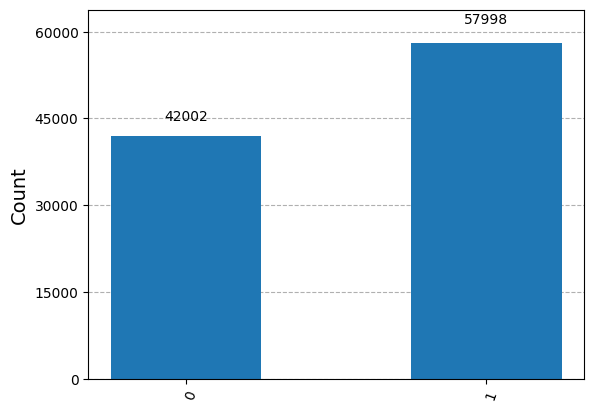

In [97]:
plot_histogram(ideal_dist)

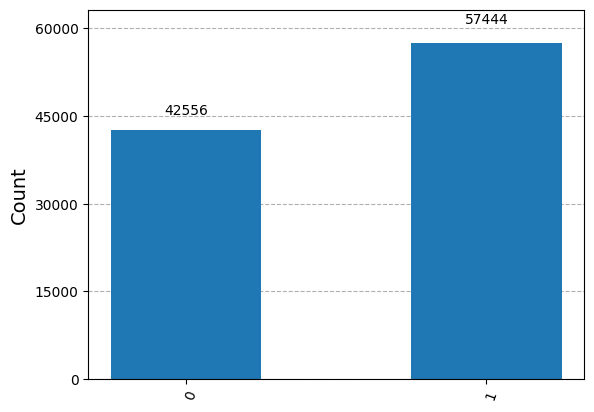

In [98]:
plot_histogram(noisy_dist)

In [ ]:
# from qiskit_ibm_runtime.fake_provider import FakeBrisbaneV2, FakeKyivV2, FakeSherbrookeV2
from qiskit_ibm_runtime.fake_provider import FakeAlgiers, FakeAlmadenV2, FakeArmonkV2, FakeAthensV2, FakeAuckland, FakeBelemV2, FakeBoeblingenV2, FakeBogotaV2, FakeBrisbane, FakeBrooklynV2, FakeBurlingtonV2, FakeCairoV2, FakeCambridgeV2, FakeCasablancaV2, FakeCusco, FakeEssexV2, FakeGeneva, FakeGuadalupeV2, FakeHanoiV2, FakeJakartaV2, FakeJohannesburgV2, FakeKawasaki, FakeKolkataV2, FakeKyiv, FakeKyoto, FakeLagosV2, FakeLimaV2, FakeLondonV2, FakeManhattanV2, FakeManilaV2, FakeMelbourneV2, FakeMontrealV2, FakeMumbaiV2, FakeNairobiV2, FakeOsaka, FakeOslo, FakeOurenseV2, FakeParisV2, FakePeekskill, FakePerth, FakePrague, FakePoughkeepsieV2, FakeQuebec, FakeQuitoV2, FakeRochesterV2, FakeRomeV2, FakeSantiagoV2, FakeSherbrooke, FakeSingaporeV2, FakeSydneyV2, FakeTorino, FakeTorontoV2, FakeValenciaV2, FakeVigoV2, FakeWashingtonV2, FakeYorktownV2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

counter = 0
failed_result = []

max_qubits_dict = {
    'FakeAlgiers': 27,
    'FakeAlmadenV2': 53,  # Adjusted based on typical backend sizes
    'FakeArmonkV2': 1,
    'FakeAthensV2': 5,
    'FakeBelemV2': 5,
    'FakeBoeblingenV2': 53,  # Adjusted based on typical backend sizes
    'FakeBogotaV2': 5,
    'FakeAuckland': 27,
    'FakeBrisbane': 127,
    'FakeBrooklynV2': 53,  # Adjusted based on typical backend sizes
    'FakeBurlingtonV2': 5,
    'FakeCairoV2': 27,
    'FakeCambridgeV2': 53,  # Adjusted based on typical backend sizes
    'FakeCasablancaV2': 7,
    'FakeCusco': 127,
    'FakeEssexV2': 5,
    'FakeFez': 156,
    'FakeGeneva': 27,
    'FakeGuadalupeV2': 16,
    'FakeHanoiV2': 27,
    'FakeJakartaV2': 7,
    'FakeJohannesburgV2': 53,  # Adjusted based on typical backend sizes
    'FakeKawasaki': 127,
    'FakeKolkataV2': 27,
    'FakeKyiv': 127,
    'FakeKyoto': 127,
    'FakeLagosV2': 7,
    'FakeLimaV2': 5,
    'FakeFractionalBackend': 5,
    'FakeLondonV2': 5,
    'FakeManhattanV2': 53,  # Adjusted based on typical backend sizes
    'FakeManilaV2': 5,
    'FakeMarrakesh': 156,
    'FakeMelbourneV2': 14,
    'FakeMontrealV2': 27,
    'FakeMumbaiV2': 27,
    'FakeNairobiV2': 7,
    'FakeOsaka': 127,
    'FakeOslo': 7,
    'FakeOurenseV2': 5,
    'FakeParisV2': 53,  # Adjusted based on typical backend sizes
    'FakePeekskill': 27,
    'FakePerth': 7,
    'FakePrague': 33,
    'FakePoughkeepsieV2': 53,  # Adjusted based on typical backend sizes
    'FakeQuebec': 127,
    'FakeQuitoV2': 5,
    'FakeRochesterV2': 53,  # Adjusted based on typical backend sizes
    'FakeRomeV2': 5,
    'FakeSantiagoV2': 53,  # Adjusted based on typical backend sizes
    'FakeSherbrooke': 127,
    'FakeSingaporeV2': 53,  # Adjusted based on typical backend sizes
    'FakeSydneyV2': 27,
    'FakeTorino': 133,
    'FakeTorontoV2': 27,
    'FakeValenciaV2': 5,
    'FakeVigoV2': 5,
    'FakeWashingtonV2': 127,
    'FakeYorktownV2': 5,
}

fake_backends = [FakeAlgiers(), FakeAlmadenV2(), FakeArmonkV2(), FakeAthensV2(), FakeBelemV2(), FakeBoeblingenV2(), FakeBogotaV2(), FakeAuckland(), FakeBrisbane(), FakeBrooklynV2(), FakeBurlingtonV2(), FakeCairoV2(), FakeCambridgeV2(), FakeCasablancaV2(), FakeCusco(), FakeEssexV2(), FakeGeneva(), FakeGuadalupeV2(), FakeHanoiV2(), FakeJakartaV2(), FakeJohannesburgV2(),  FakeKawasaki(), FakeKolkataV2(), FakeKyiv(), FakeKyoto(), FakeLagosV2(), FakeLimaV2(), FakeLondonV2(), FakeManhattanV2(), FakeManilaV2(), FakeMelbourneV2(), FakeMontrealV2(), FakeMumbaiV2(), FakeNairobiV2(), FakeOsaka(), FakeOslo(), FakeOurenseV2(), FakeParisV2(), FakePeekskill(), FakePerth(), FakePrague(), FakePoughkeepsieV2(), FakeQuebec(), FakeQuitoV2(), FakeRochesterV2(), FakeRomeV2(), FakeSantiagoV2(), FakeSherbrooke(), FakeSingaporeV2(), FakeSydneyV2(), FakeTorino(), FakeTorontoV2(), FakeValenciaV2(), FakeVigoV2(), FakeWashingtonV2(), FakeYorktownV2()]

for fake_backend in fake_backends:
    # Generate noise model from the fake backend
    noise_model = NoiseModel.from_backend(fake_backend)

    backend_name = type(fake_backend).__name__
    max_qubits = min(max_qubits_dict[backend_name], 12) 

    # max_qubits = min(fake_backend.configuration().n_qubits, 12)
    max_qubits = min(max_qubits, 12)

    
    for _ in range(10):
        #most experiments use shallow circuits
        max_depth = 5  # Maximum depth
        depth = np.random.randint(1, max_depth + 1)  # Random depth between 1 and max_depth

        # Ensure that we have sufficient qubits
        if max_qubits >= 10:
            while True:
                qubits = np.random.lognormal(mean=mu, sigma=sigma)
                
                # Randomly decide whether to round up or down
                round_choice = np.random.choice([0, 1])  # 0 for floor, 1 for ceil
                
                if round_choice == 0:
                    qubits = np.floor(qubits)
                else:
                    qubits = np.ceil(qubits)

                if qubits >= 1 and qubits <= max_qubits:
                    break
        else:
            qubits = np.random.randint(1, max_qubits+1)
        
        # Convert to integer (already done by floor or ceil)
        qubits = int(qubits)

        circ = random_circuit(qubits, depth, measure=True)
        
        # Create simulators
        ideal_simulator = AerSimulator()
        noisy_simulator = AerSimulator(noise_model=noise_model)

        # Transpile the circuit for both simulators
        circ_ideal = transpile(circ, ideal_simulator)
        circ_noisy = transpile(circ, noisy_simulator)

        # Run ideal simulation
        ideal_result = ideal_simulator.run(circ_ideal, shots=100000).result()
        ideal_dist = ideal_result.get_counts()

        # Run noisy simulation
        noisy_result = noisy_simulator.run(circ_noisy, shots=100000).result()
        noisy_dist = noisy_result.get_counts()

        entropy_ideal = calculate_entropy(ideal_dist)
        entropy_noisy = calculate_entropy(noisy_dist)

        if entropy_ideal < entropy_noisy:
            counter += 1
        else:
            failed_result.append(circ)


In [11]:
print(counter)

545


In [12]:
print(failed_result)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3027d4320>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30368db20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3028a7590>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x17f70b8c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30e9fc0b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x314f19460>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x316d999a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30f0fc560>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x311486570>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x316cee930>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x314c77dd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x311a92d20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x314a5fb00>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x316637320>, <qiskit.circuit.qua

In [13]:
for result in failed_result:
    qc = result
    num_qubits = qc.num_qubits

    circ_ideal = transpile(qc, ideal_simulator)
    circ_noisy = transpile(qc, noisy_simulator)

    # Run ideal simulation
    ideal_result = ideal_simulator.run(circ_ideal, shots=100000).result()
    ideal_dist = ideal_result.get_counts()

    # Run noisy simulation
    noisy_result = noisy_simulator.run(circ_noisy, shots=100000).result()
    noisy_dist = noisy_result.get_counts()

    entropy_ideal = calculate_entropy(ideal_dist)
    entropy_noisy = calculate_entropy(noisy_dist)
    print(num_qubits, entropy_ideal, entropy_noisy)

1 0.9999862874287302 0.9999969980380767
1 0.9999578948241548 0.9999932455798166
1 0.9999907549018907 0.9999985042132645
1 0.9999878741142085 0.9999695228526493
1 0.9999986657952149 0.9999997573386805
1 0.9967147600576339 0.9972717373384966
1 0.9999999166122251 0.9999994664913081
3 2.999605112613056 2.9993624288850076
1 0.9999990951414812 0.9999923337935128
1 0.9999261223654499 0.9997423121094946
1 0.9999956346889425 0.9999877555240084
1 0.9999945844045791 0.9999980598628393
1 0.9999859074204152 0.9999886880871585
3 2.9999069283152906 2.9998921579846156
1 0.9999965086751847 0.9999939334588499


Note that in the above experiments we see that the entropy does not increases in cases where the entropy is already close to the maximum. We have shown in the paper that the maximum entropy is equal to the number of qubits used in the experiment. And also, we have mentioned that such states whose desired states are all the possible outcomes of measurements are not of much use in practise and are not considered in our experiments.